# This notebook will help understand what are the effects of resolution, scale and noise on the wasserstein and the l2 metric

We will look at how increasing the resolution(number of bins) on the same area, increases the wasserstein distance. I would expect the distance to become smaller and to converge to some value.

## Some Extra functions and imports

In [87]:
import numpy as np
import ot
from ot.datasets import make_1D_gauss
import pandas as pd
import matplotlib.pyplot as plt
from utils.Visualizations import *
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets
import seaborn as sns
from tqdm import tqdm
from scipy.stats import norm

In [117]:
def create_distribs_and_costs(res, noise, scale_parameter=1, distance_metric='L1'):
    X = np.linspace(0,scale_parameter,res)
    p = norm.pdf(X, scale_parameter * 0.375, scale_parameter * 0.1)
    q = norm.pdf(X, scale_parameter * 0.625, scale_parameter * 0.1)

    C = np.zeros([res, res], dtype=np.float64)
    if distance_metric == 'L1':
        dist = lambda a, b: abs(a - b)
    elif distance_metric == 'L2':
        dist = lambda a, b: (a - b) ** 2
    else:
        raise ValueError('Invalid distance metric. Must be either "L1" or "L2".')
    for it1 in range(res):
        for it2 in range(res):
            C[it1, it2] = dist(X[it1], X[it2])

    noise_p = np.random.normal(0, noise, res)
    noise_q = np.random.normal(0, noise, res)

    p_noised = p + noise_p
    q_noised = q + noise_q

    p_pos, p_neg = split_signed_measure(p_noised)
    q_pos, q_neg = split_signed_measure(q_noised)

    p_post = p_pos + q_neg
    q_post = p_neg + q_pos

    return p, q, p_post/p_post.sum(), q_post/q_post.sum(), C

In [145]:
def run_experiment_and_append(df, res, noise_param, scale_param, reg_m_param=1):
    results_classic = []
    results_noised = []
    ratios_emd = []
    results_linear = []
    results_linear_noised = []
    ratios_linear = []

    for i in range(100):
        p, q, p_post, q_post, C = create_distribs_and_costs(res, noise_param, scale_param)

        results_classic_add = calc_transport_pot_emd(p, q, C)[1]
        plan_noised, log_noised = ot.unbalanced.mm_unbalanced(a=p_post, b=q_post, M=C, reg_m=reg_m_param, log=True)
        results_noised_add = log_noised['cost']

        results_classic.append(results_classic_add)
        results_noised.append(results_noised_add)
        ratios_emd.append(results_classic_add / results_noised_add)

        results_linear.append(np.linalg.norm(p - q))
        results_linear_noised.append(np.linalg.norm(p_post - q_post))
        ratios_linear.append(np.linalg.norm(p - q) / np.linalg.norm(p_post - q_post))

    # Create new row
    new_row = {
        'Res': res,
        'Noise_Param': noise_param,
        'Scale_Param': scale_param,
        'Reg_M_Param': reg_m_param,
        'Distances_Classic': np.mean(results_classic),
        'Distances_Noised': np.mean(results_noised),
        'Ratios_EMD': np.mean(ratios_emd),
        'Distances_Linear': np.mean(results_linear),
        'Distances_Linear_Noised': np.mean(results_linear_noised),
        'Ratios_Linear': np.mean(ratios_linear)
    }

    # Append new row to DataFrame
    return df._append(new_row, ignore_index=True)

## Looking at the normal case, to get a sense of things

In [341]:
resolution = 100
noise_param = 1e-2
scale_param = 100
X = np.linspace(0,scale_param,resolution)

p = norm.pdf(X, scale_param * 0.25, scale_param * 0.05)
p = p / p.sum()
q = norm.pdf(X, scale_param * 0.75, scale_param * 0.05)
q = q / q.sum()

noise_p = np.random.normal(0, noise_param, resolution)
noise_q = np.random.normal(0, noise_param, resolution)

In [342]:
q.sum()

1.0

In [343]:
C = np.zeros([resolution,resolution],dtype=np.float64)
dist_f1 = lambda a,b : abs(a-b)
dist_f2 = lambda a,b : (a-b)**2
for it1 in range(resolution):
    for it2 in range(resolution):
        C[it1,it2] = dist_f1(X[it1],X[it2])

In [344]:
p_noised = p + noise_p
q_noised = q + noise_q

p_pos, p_neg = split_signed_measure(p_noised)
q_pos, q_neg = split_signed_measure(q_noised)

p_post = p_pos + q_neg
q_post = p_neg + q_pos

p_post = p_post / p_post.sum()
q_post = q_post / q_post.sum()

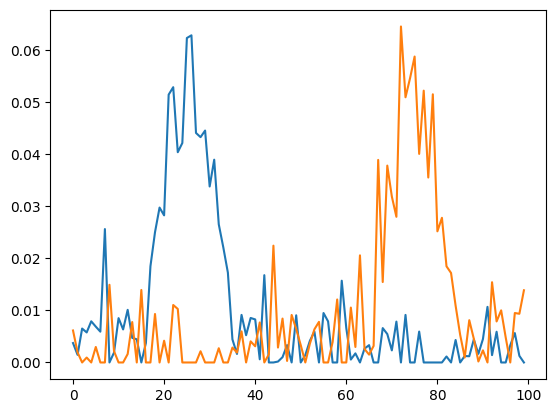

In [345]:
plt.plot(p_post)
plt.plot(q_post)

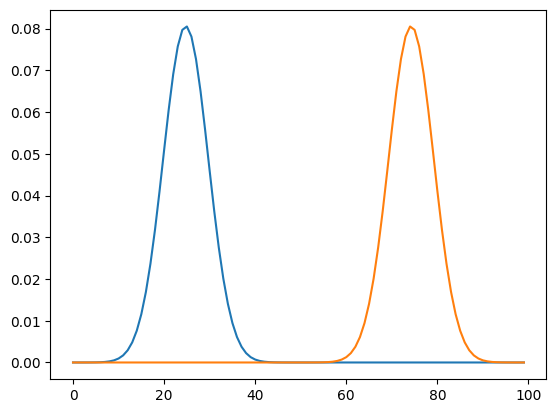

In [346]:
plt.plot(p)
plt.plot(q)

In [347]:
results_classic = calc_transport_pot_emd(p, q, C)[1]
results_noised = calc_transport_pot_emd(p_post, q_post, C)[1]

print('Results on classic EMD:', results_classic)
print('Results on the unbalanced noised:', results_noised)
print('Ratio:', results_classic/results_noised)

print('Results on normal linear:', np.linalg.norm(p-q))
print('Results on unbalanced linear:', np.linalg.norm(p_post-q_post))
print('Ratio:', np.linalg.norm(p-q)/np.linalg.norm(p_post-q_post))

Results on classic EMD: 49.99999144415974
Results on the unbalanced noised: 36.40557253823503
Ratio: 1.3734158799905467
Results on normal linear: 0.3376058803303331
Results on unbalanced linear: 0.23952296549941463
Ratio: 1.4094927374768087


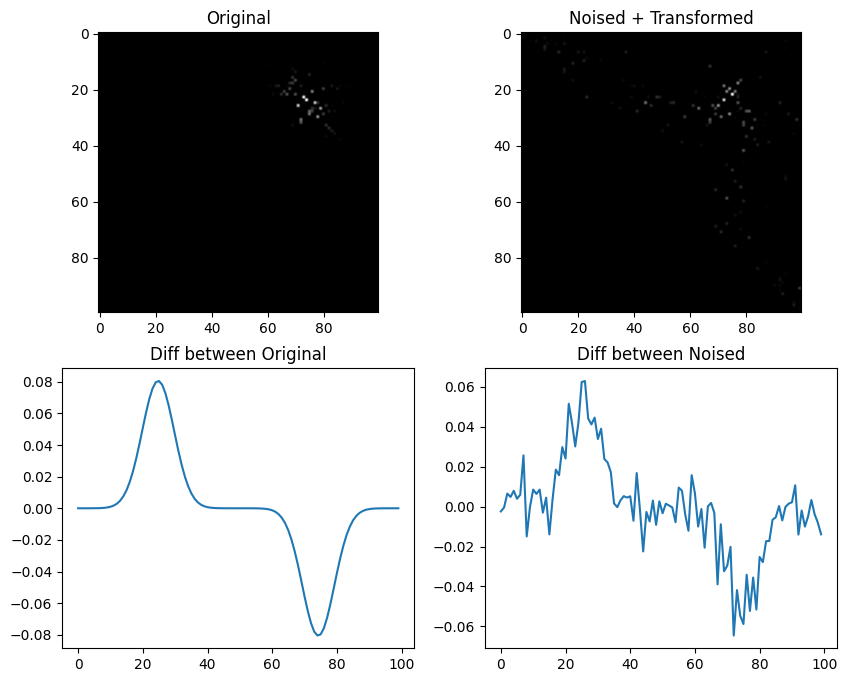

In [348]:
fig = plt.figure(figsize=(10,8))

fig.add_subplot(2,2,1)
plt.title('Original')
plt.imshow(ot.emd(a=p, b=q, M=C), cmap='gray')

fig.add_subplot(2,2,2)
plt.title('Noised + Transformed')
plt.imshow(calc_transport_pot_emd(p_post, q_post, C)[0], cmap='gray')

fig.add_subplot(2,2,3)
plt.title('Diff between Original')
plt.plot(p - q)

fig.add_subplot(2,2,4)
plt.title('Diff between Noised')
plt.plot(p_post - q_post)

In [355]:
from scipy.sparse import csr_matrix
plan = ot.emd(a=p, b=q, M=C)

In [356]:
A = csr_matrix(plan * C)
len(A.data)

183

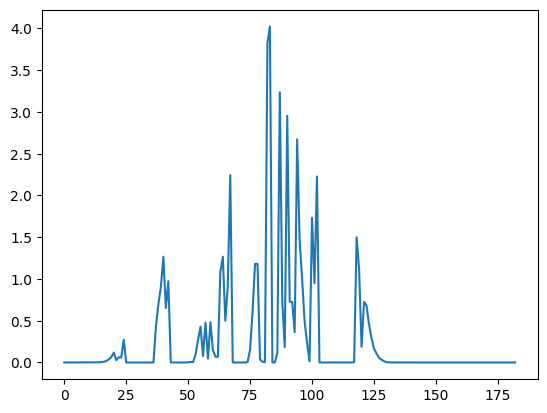

In [357]:
plt.plot(A.data)

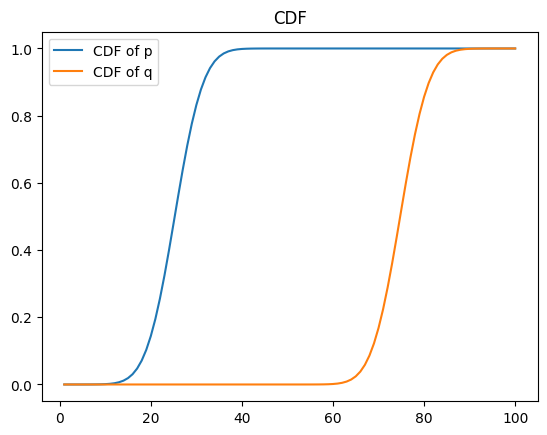

In [315]:
cumsum_p = np.cumsum(p)
cumsum_q = np.cumsum(q)
x_values = np.arange(1, resolution + 1)

plt.plot(x_values, cumsum_p, label='CDF of p')
plt.plot(x_values, cumsum_q, label='CDF of q')

plt.title('CDF')
plt.legend()

plt.show()

In [316]:
# We can calculate the sum of the cumsums since we are trying to find the integral, which will be the same whether we take the normal
# function or the inverse one.
diff = np.abs(cumsum_p - cumsum_q)
print(diff.sum())

49.499991529718145


## Looking at the effects of h, noise and scale.

### How does scale effect the whole thing?

In [120]:
res = 100
scale_parameter = 20
noise = 1e-2

X = np.linspace(0,scale_param,resolution)
p = norm.pdf(X, scale_param * 0.375, scale_param * 0.1)
q = norm.pdf(X, scale_param * 0.625, scale_param * 0.1)

C = np.zeros([res,res],dtype=np.float64)
dist_f1 = lambda a,b : abs(a-b)
dist_f2 = lambda a,b : (a-b)**2
for it1 in range(res):
    for it2 in range(res):
        C[it1,it2] = dist_f1(X[it1],X[it2])
            
noise_p = np.random.normal(0, noise, res)
noise_q = np.random.normal(0, noise, res)

p_noised = p + noise_p
q_noised = q + noise_q

p_pos, p_neg = split_signed_measure(p_noised)
q_pos, q_neg = split_signed_measure(q_noised)

p_post = p_pos + q_neg
q_post = p_neg + q_pos

In [144]:
results_classic = calc_transport_pot_emd(p, q, C)[1]
plan_noised, log_noised = ot.unbalanced.mm_unbalanced(a = p_post, b = q_post, M = C, reg_m=2000, log=True)
results_noised = log_noised['cost']

print('Results on classic EMD:', results_classic)
print('Results on the unbalanced noised:', results_noised)
print(results_classic/results_noised)

print('Results on normal linea r:', np.linalg.norm(p-q))
print('Results on unbalanced linear:', np.linalg.norm(p_post-q_post))
print(np.linalg.norm(p-q)/np.linalg.norm(p_post-q_post))

Results on classic EMD: 24.742488077566424
Results on the unbalanced noised: 26.953193917114167
0.9179798191507079
Results on normal linea r: 0.2101118062403516
Results on unbalanced linear: 0.24486499935109712
0.8580720266153065


### Creating a full DataFrame

In [208]:
# Initialize DataFrame
columns = ['Res', 'Noise_Param', 'Scale_Param', 'Distances_Classic', 'Distances_Noised', 
           'Ratios_EMD', 'Distances_Linear', 'Distances_Linear_Noised', 'Ratios_Linear']
df = pd.DataFrame(columns=columns)

In [209]:
res_values = [10,50,100]
noise_values = [5e-2, 1e-2, 5e-3, 1e-3]
scale_values = [1,10,20,100]

In [210]:
for res in res_values:
    for noise in noise_values:
        for scale in scale_values:
            df = run_experiment_and_append(df, res=res, noise_param=noise, scale_param=scale)

C:\Users\eriki\AppData\Local\Temp\ipykernel_23496\2143969769.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return df._append(new_row, ignore_index=True)


In [211]:
len(df.index)

48

## Looking into the CDF

In [180]:
res = 100
scale_parameter = 1
noise = 1e-2

p = make_1D_gauss(res, scale_parameter * np.floor(1 * res / 4.), scale_parameter * 2.).flatten()
q = make_1D_gauss(res, scale_parameter * np.floor(5 * res / 8.), scale_parameter * 2.).flatten()
X = np.linspace(0,scale_parameter,res)

C = np.zeros([res,res],dtype=np.float64)
dist_f1 = lambda a,b : abs(a-b)
dist_f2 = lambda a,b : (a-b)**2
for it1 in range(res):
    for it2 in range(res):
        C[it1,it2] = dist_f1(X[it1],X[it2])
            
noise_p = np.random.normal(0, noise, res)
noise_q = np.random.normal(0, noise, res)

p_noised = p + noise_p
q_noised = q + noise_q

p_pos, p_neg = split_signed_measure(p_noised)
q_pos, q_neg = split_signed_measure(q_noised)

p_post = p_pos + q_neg
q_post = p_neg + q_pos

Looking into p:

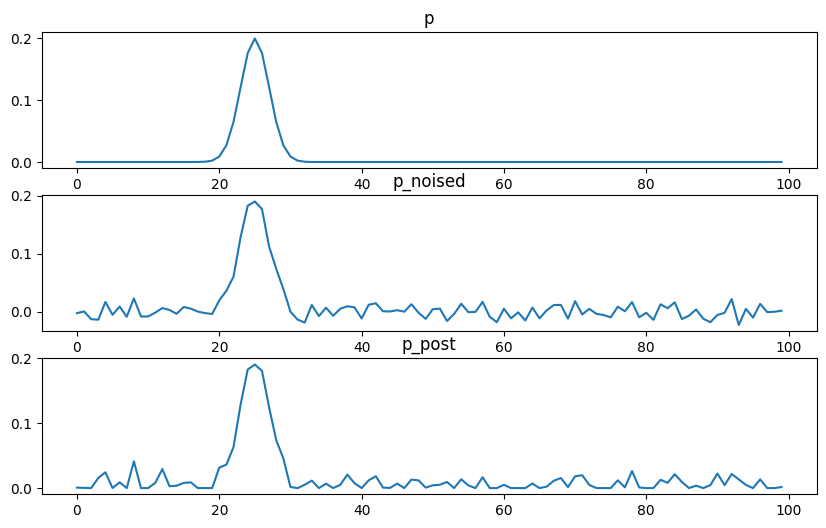

In [164]:
#looking into p

fig = plt.figure(figsize=(10, 6))

fig.add_subplot(3, 1, 1)
plt.title('p')
plt.plot(p)

fig.add_subplot(3, 1, 2)
plt.title('p_noised')
plt.plot(p_noised)

fig.add_subplot(3, 1, 3)
plt.title('p_post')
plt.plot(p_post)

Calculating the ECDF(Empirical Cumulative Distribution Function)

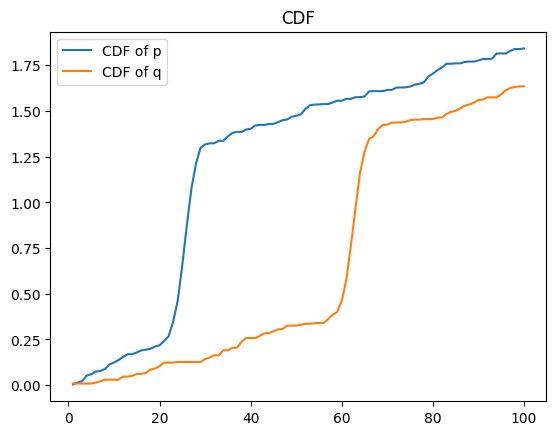

In [184]:
cumsum_p = np.cumsum(p_post)
cumsum_q = np.cumsum(q_post)
x_values = np.arange(1, res + 1)

plt.plot(x_values, cumsum_p, label='CDF of p')
plt.plot(x_values, cumsum_q, label='CDF of q')

plt.title('CDF')
plt.legend()

plt.show()

We will look at the difference between the CDF's and will get the value of the optimal transport, since the 1d version can be calculated using quantiles

In [204]:
diff = np.abs(cumsum_p - cumsum_q)
percentile_intervals = np.linspace(0,1,101)

percentile_values_p = np.zeros_like(percentile_intervals)
percentile_values_q = np.zeros_like(percentile_intervals)

# Calculate percentile values for p
for i, val in enumerate(percentile_intervals):
    idx = np.argmax(cumsum_p >= val)
    percentile_values_p[i] = p_post[idx]

# Calculate percentile values for q
for i, val in enumerate(percentile_intervals):
    idx = np.argmax(cumsum_q >= val)
    percentile_values_q[i] = q_post[idx]

diff2 = np.abs(percentile_values_p - percentile_values_q)
print(diff2.sum())

3.2327832504503164


In [193]:
print('The difference between CDFs is:', diff.sum())

The difference between CDFs is: 53.71942820657816


In [205]:
plan, log = ot.unbalanced.mm_unbalanced(a=p_post, b=q_post, M=C, reg_m=100, log=True)
cost_noised = log['cost']
print('The EMD between distributions is', cost_noised)

The EMD between distributions is 0.5063400250044428
